In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
data1 = pd.read_csv('dim_customers.csv')
data1.head(3) # no nulls, 

,customer_id,age_group,city,occupation,gender,marital status,avg_income
0,ATQCUS1825,45+,Bengaluru,Salaried IT Employees,Male,Married,73523
1,ATQCUS0809,25-34,Hyderabad,Salaried Other Employees,Male,Married,39922
2,ATQCUS0663,25-34,Chennai,Salaried Other Employees,Male,Married,37702


In [3]:
data2 = pd.read_csv('fact_spends.csv')
data2.head(3)

,customer_id,month,category,payment_type,spend
0,ATQCUS1371,July,Health & Wellness,Credit Card,1114
1,ATQCUS0368,October,Groceries,Credit Card,1466
2,ATQCUS0595,May,Health & Wellness,Credit Card,387


In [4]:
# UNIVARIATE ANALYSIS  # 4000 unique customers
print(data1.shape, data2.shape)
for col in ['gender', 'age_group', 'marital status', 'city', 'occupation']:
    print()
    print(data1[col].value_counts())
# 2 genders(1403 F, 2597M)~(1400F,2600M), married status (married-3136, single-864)
# 4 age groups(21-24 691; 25-34 1498; 35-45 1273; 45+ 538) , 5 cities (Mumbai 1078; Chennai 834; Bengaluru 751; Delhi NCR 744; Hyderabad 593)
# occcupation (Salaried IT Employees 1294; Salaried Other Employees 893; Freelancers 784; Business Owners 630; Government Employees 399)

(4000, 7) (864000, 5)

gender
Male      2597
Female    1403
Name: count, dtype: int64

age_group
25-34    1498
35-45    1273
21-24     691
45+       538
Name: count, dtype: int64

marital status
Married    3136
Single      864
Name: count, dtype: int64

city
Mumbai       1078
Chennai       834
Bengaluru     751
Delhi NCR     744
Hyderabad     593
Name: count, dtype: int64

occupation
Salaried IT Employees       1294
Salaried Other Employees     893
Freelancers                  784
Business Owners              630
Government Employees         399
Name: count, dtype: int64


In [5]:
# BI-VARIATE ANALYSIS
data1.groupby(['gender'])['avg_income'].mean().round(-2).sort_values() # avg incomes didnt differ much by gender
data1.groupby(['marital status'])['avg_income'].mean().round(-2).sort_values() # singles - 46k (can spend more), married - 53k (have responsibilities but needs for credit card)
data1.groupby(['age_group'])['avg_income'].mean().round(-2).sort_values() #  21-24 41k; 25-34 52k; 35-45 54k; 45+ 61k - incremental (40-60k)
data1.groupby(['city'])['avg_income'].mean().round(-2).sort_values() # 51100-52300; not much difference BCMDH order
data1.groupby(['occupation'])['avg_income'].mean().round(-2).sort_values()
# freelancers 35k; other emps 39k; govt emps 52k; IT emps 61.5k; business owners 70k)


marital status
Single     45600.0
Married    53300.0
Name: avg_income, dtype: float64

In [6]:
#  Bi-variate distribution
pd.crosstab(data1['age_group'],data1['gender'],margins=True)         # f:m 21-24 (~3:5), 25-34 (~11:20), 35-45 (~1:2), 45+ (~1:2)
pd.crosstab(data1['age_group'],data1['marital status'],margins=True) # most singles between 21-24 (5/7), 25-34(1/5), 35-45 (1/17), 45+ (1/49)
pd.crosstab(data1['marital status'],data1['gender'],margins=True)    # 1136F married & 2000M; 267F single while 600M single

gender,Female,Male,All
marital status,,,
Married,1136,2000,3136
Single,267,597,864
All,1403,2597,4000


In [7]:
# Average Income across different groups
pd.crosstab(index = data1['gender'],columns = data1['age_group'],values = data1['avg_income'],aggfunc='mean').round(0)
pd.crosstab(index = data1['occupation'],columns = data1['city'],values = data1['avg_income'],aggfunc='mean', margins=True).round(0)
# Business Owners earn the most and FreeLancers the least; Hyderabad people earn the most on average

city,Bengaluru,Chennai,Delhi NCR,Hyderabad,Mumbai,All
occupation,,,,,,
Business Owners,70428.0,70232.0,69736.0,70210.0,69945.0,70091.0
Freelancers,35115.0,35138.0,35377.0,35502.0,34427.0,35058.0
Government Employees,52893.0,52076.0,51564.0,52232.0,51533.0,52035.0
Salaried IT Employees,61867.0,62595.0,61594.0,61512.0,60424.0,61500.0
Salaried Other Employees,38797.0,39002.0,38910.0,39526.0,38152.0,38793.0
All,51073.0,51321.0,51983.0,52345.0,51720.0,51657.0


----------------------------------------------------------------------------------------------------------

In [9]:
data2 = pd.read_csv('fact_spends.csv')
data2.info() 
# 864k rows, no nulls, columns: (cust_id, month, category, payment_type, spend) # 4000 cust * 6 months * 9 categories * 4 payment_types = 864000 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864000 entries, 0 to 863999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   customer_id   864000 non-null  object
 1   month         864000 non-null  object
 2   category      864000 non-null  object
 3   payment_type  864000 non-null  object
 4   spend         864000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 33.0+ MB


##   INCOME UTILIZATION RATIO

In [11]:
# average spending by each customer
data3 = data1.merge(((data2.groupby('customer_id')['spend'].sum())/6).round(0), on= 'customer_id')
data3.columns = ['customer_id', 'age_group', 'city', 'occupation', 'gender', 'marital status', 'avg_income', 'avg_spend']
data3.head()

,customer_id,age_group,city,occupation,gender,marital status,avg_income,avg_spend
0,ATQCUS1825,45+,Bengaluru,Salaried IT Employees,Male,Married,73523,32401.0
1,ATQCUS0809,25-34,Hyderabad,Salaried Other Employees,Male,Married,39922,16519.0
2,ATQCUS0663,25-34,Chennai,Salaried Other Employees,Male,Married,37702,11517.0
3,ATQCUS0452,25-34,Delhi NCR,Government Employees,Male,Married,54090,20385.0
4,ATQCUS3350,21-24,Bengaluru,Freelancers,Male,Single,28376,12251.0


In [12]:
# avg income and average spend of bengluru city : data3.loc[data3['city']=='Bengaluru'][['avg_income','spend']].sum()/751
by_age = data3.groupby('age_group')[['avg_income','avg_spend']].mean()
by_age['income_util_ratio'] = (100*by_age['avg_spend']/by_age['avg_income']).round(0)
by_age

by_city = data3.groupby('city')[['avg_income','avg_spend']].mean()
by_city['income_util_ratio'] = (100*by_city['avg_spend']/by_city['avg_income']).round(0)
by_city

by_occ = data3.groupby('occupation')[['avg_income','avg_spend']].mean()
by_occ['income_util_ratio'] = (100*by_occ['avg_spend']/by_occ['avg_income']).round(0)
by_occ

,avg_income,avg_spend,income_util_ratio
occupation,,,
Business Owners,70091.179365,23281.646032,33.0
Freelancers,35058.253827,16058.387755,46.0
Government Employees,52034.834586,15088.716792,29.0
Salaried IT Employees,61499.673107,31391.071870,51.0
Salaried Other Employees,38793.436730,16332.895857,42.0


## SPENDING ANALYSIS

In [14]:
total_spend_by_category = data2.groupby('category')['spend'].sum().reset_index()                   # 
total_spend_by_two_categories = data2.groupby(['category','payment_type'])['spend'].sum().reset_index()

<Axes: xlabel='payment_type'>

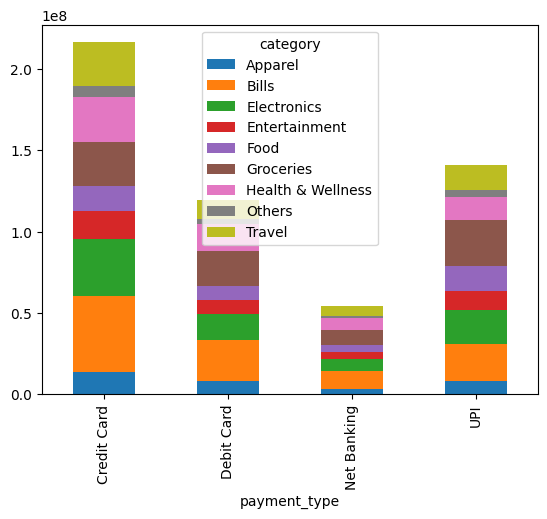

In [15]:
temp = data2.groupby(['payment_type', 'category'])['spend'].sum().reset_index()
import seaborn as sns
temp.pivot(index='payment_type',columns='category',values='spend').plot(kind='bar', stacked=True,)